# CNN on the mnist dataset
We apply a CNN on the mnist publicaly available dataset
We first preprocess the data and split it to train/test datasets
We then construct an image generator and fit a CNN on our data using Keras

# Data Preprocessing

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import imageio
import os
import numpy as np
import struct
from sklearn.preprocessing import StandardScaler
#enable eagerexecution
try:
    tf.enable_eager_execution ()
except Exception:
    pass

#example of reading an image
img=imageio.imread('C://Users//marwe//Downloads//Sample-Images-in-the-RGB-color-space.jpg',pilmode='RGB')
print("image shape:",img.shape)
print("number of channel:",img.shape[2])
print("image data typme",img.dtype)
print("some random pixels:",img[100:102,100,::])

#load mnist
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
    return images, labels

X_data, y_data = load_mnist("C:\\Users\\marwe\\Desktop\\neural", kind='train')
X_test, y_test = load_mnist("C:\\Users\\marwe\\Desktop\\neural", kind='t10k')

#X_trai, validation and test
X_train, y_train = X_data[:50000,:], y_data[:50000]
X_valid, y_valid = X_data[50000:,:], y_data[50000:]
print('Training: ', X_train.shape, y_train.shape)
print('Validation: ', X_valid.shape, y_valid.shape)
print('Test Set: ', X_test.shape, y_test.shape)



image shape: (160, 208, 3)
number of channel: 3
image data typme uint8
some random pixels: [[81 99 47]
 [41 65 17]]
Training:  (50000, 784) (50000,)
Validation:  (10000, 784) (10000,)
Test Set:  (10000, 784) (10000,)


# We define an image generator and fit a CNN on the mnist dataset

After preprocessing the data and constructing an image generator, we fit a CNN to determine which class every image belongs to (0,1...,9)

The CNN is constructed using Keras by stacking a Conv2D, MaxPooling2D, Flatten and end with Dense layers to classify our images
We also use Dropout Layers to eliminate overiffitting issues

Notice we reach a very high test accuracy levels (almost 99%)
 

In [3]:
#Generate random batches
def Gen_batches(X,y,batch_size=64,shuffle=False,random_seed=None):
    idx=np.arange(y.shape[0])
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X=X[idx]
        y=y[idx]
    for i in range(0,y.shape[0],batch_size):
        yield (X[i:i+batch_size,:],y[i:i+batch_size])


#normalizing the data
sc=StandardScaler()
X_train_std=sc.fit_transform(X_train).reshape(X_train.shape[0],28,28,1)
X_valid_std=sc.transform(X_valid).reshape(X_valid.shape[0],28,28,1)
X_test_std=sc.transform(X_test).reshape(X_test.shape[0],28,28,1)


#implement our CNN using keras
import tensorflow.keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from numpy.testing import assert_allclose

#onehot encoder
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
y_test = keras.utils.to_categorical(y_test,10)

#create cnn model
model = Sequential()
model.add(Conv2D(32,kernel_size=(5,5),strides=(1,1),activation='relu',input_shape=(28,28,1)))
model.add(Dropout(rate=0.2))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(64,kernel_size=(5,5),strides=(1,1),activation='relu'))
model.add(Dropout(rate=0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))
#compile model and minimize using sgd
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])



model.fit(X_train_std, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_valid_std, y_valid))





score = model.evaluate(X_test_std, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])




Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 66s 1ms/step - loss: 0.1369 - accuracy: 0.9577 - val_loss: 0.0524 - val_accuracy: 0.9860
Epoch 2/5
50000/50000 [==============================] - 69s 1ms/step - loss: 0.0486 - accuracy: 0.9848 - val_loss: 0.0458 - val_accuracy: 0.9883
Epoch 3/5
50000/50000 [==============================] - 69s 1ms/step - loss: 0.0322 - accuracy: 0.9898 - val_loss: 0.0402 - val_accuracy: 0.9893
Epoch 4/5
50000/50000 [==============================] - 68s 1ms/step - loss: 0.0248 - accuracy: 0.9920 - val_loss: 0.0378 - val_accuracy: 0.9902
Epoch 5/5
50000/50000 [==============================] - 68s 1ms/step - loss: 0.0192 - accuracy: 0.9936 - val_loss: 0.0419 - val_accuracy: 0.9894
Test loss: 0.03978591469187522
Test accuracy: 0.9883000254631042


## Plotting Missclassified images:

We plot some of the missclassified images to identify possible reasons for such errors. We notice that the handwriting can sometimes be unclear and hard to read even for a human being. We therefore conclude that our CNN does a pretty good job classifying our images! 

plotting few of our wrong guesses:


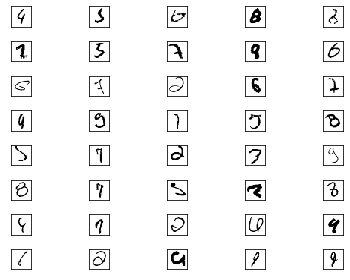

In [8]:
import matplotlib.pyplot as plt

y_pred=model.predict(X_test_std)
#print(y_pred.shape)
#print(y_pred[0,:])
y_classes = y_pred.argmax(axis=-1)
#print(y_classes[0])
print('plotting few of our wrong guesses:')

X_testo, y_testo = load_mnist("C:\\Users\\marwe\\Desktop\\neural", kind='t10k')
X_testo=X_testo.reshape(X_testo.shape[0],28,28)

fig, ax = plt.subplots(nrows=8,ncols=5,sharex=True,sharey=True)

ax= ax.flatten()

for i in range(40):
    img = X_testo[y_classes != y_testo][i]
    ax[i].imshow(img, cmap='Greys')


ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()